# Importing Libraries

In [44]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.stat import Correlation
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
pd.set_option('display.max_columns', None)

spark = SparkSession.builder.appName("IndividualAssignment").getOrCreate()

# Reading Data

In [2]:
user_defined_schema = StructType() \
        .add("year", IntegerType(), True) \
        .add("month", IntegerType(), True) \
        .add("carrier", StringType(), True) \
        .add("carrier_name", StringType(), True) \
        .add("airport", StringType(), True) \
        .add("airport_name", StringType(), True) \
        .add("arr_flights", IntegerType(), True) \
        .add("arr_del15", IntegerType(), True) \
        .add("carrier_ct", DoubleType(), True) \
        .add("weather_ct", DoubleType(), True) \
        .add("nas_ct", DoubleType(), True) \
        .add("security_ct", DoubleType(), True) \
        .add("late_aircraft_ct", DoubleType(), True) \
        .add("arr_cancelled", IntegerType(), True) \
        .add("arr_diverted", IntegerType(), True) \
        .add("arr_delay", IntegerType(), True) \
        .add("carrier_delay", IntegerType(), True) \
        .add("weather_delay", IntegerType(), True) \
        .add("nas_delay", IntegerType(), True) \
        .add("security_delay", IntegerType(), True) \
        .add("late_aircraft_delay", IntegerType(), True)

In [3]:
df = spark.read.format("csv") \
        .option("header", True) \
        .option("quote", "\"") \
        .option("escape", "\"") \
        .option("nullValue", "null") \
        .schema(user_defined_schema) \
        .load("hdfs://namenode:8020/datasets/Airline_Delay_Cause.csv")

# Exploratory Data Analysis

In [4]:
#Shape of the dataframe
print((df.count(), len(df.columns)))

(318017, 21)


In [5]:
list(df.columns)

['year',
 'month',
 'carrier',
 'carrier_name',
 'airport',
 'airport_name',
 'arr_flights',
 'arr_del15',
 'carrier_ct',
 'weather_ct',
 'nas_ct',
 'security_ct',
 'late_aircraft_ct',
 'arr_cancelled',
 'arr_diverted',
 'arr_delay',
 'carrier_delay',
 'weather_delay',
 'nas_delay',
 'security_delay',
 'late_aircraft_delay']

In [6]:
#Schema of the Dataframe
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- carrier: string (nullable = true)
 |-- carrier_name: string (nullable = true)
 |-- airport: string (nullable = true)
 |-- airport_name: string (nullable = true)
 |-- arr_flights: integer (nullable = true)
 |-- arr_del15: integer (nullable = true)
 |-- carrier_ct: double (nullable = true)
 |-- weather_ct: double (nullable = true)
 |-- nas_ct: double (nullable = true)
 |-- security_ct: double (nullable = true)
 |-- late_aircraft_ct: double (nullable = true)
 |-- arr_cancelled: integer (nullable = true)
 |-- arr_diverted: integer (nullable = true)
 |-- arr_delay: integer (nullable = true)
 |-- carrier_delay: integer (nullable = true)
 |-- weather_delay: integer (nullable = true)
 |-- nas_delay: integer (nullable = true)
 |-- security_delay: integer (nullable = true)
 |-- late_aircraft_delay: integer (nullable = true)



In [7]:
#Description of each column
df.describe().toPandas()

summary                year              month carrier  \
0   count              318017             318017  318017   
1    mean  2012.4509570243101  6.497844454856187    None   
2  stddev   5.678295724524459  3.459423049039796    None   
3     min                2003                  1      9E   
4     max                2022                 12      YX   

             carrier_name airport                            airport_name  \
0                  318017  318017                                  318017   
1                    None    None                                    None   
2                    None    None                                    None   
3  ATA Airlines d/b/a ATA     ABE         Aberdeen, SD: Aberdeen Regional   
4          Virgin America     YUM  Yuma, AZ: Yuma MCAS/Yuma International   

          arr_flights           arr_del15          carrier_ct  \
0              317529              317289              317529   
1  381.76398376211307   72.90440261086896   21.07298004276763   
2  1027.1489942399676  198.93559457079257  47.671306445047705   
3                   1                   0                 0.0   
4               21977                6377             1792.07   

           weather_ct             nas_ct         security_ct  \
0              317529             317529              317529   
1  2.6163788819289047  24.00522786895085  0.1790366864128952   
2    9.96854888843857   85.1137567039761  0.8448335040172659   
3                 0.0              -0.01                 0.0   
4              717.94            4091.27               80.56   

     late_aircraft_ct      arr_cancelled        arr_diverted  \
0              317529             317529              317529   
1  24.975734184908763  7.207256660021605  0.8676719291781223   
2   75.27522305646971  37.21630093080396  3.9157604062744498   
3                 0.0                  0                   0   
4             1885.47               4951                 256   

           arr_delay       carrier_delay       weather_delay  \
0             317529              317529              317529   
1  4209.947535500694  1286.5835026092104  220.56754186231808   
2   12518.9078538858    3515.39726340845   861.5214402372505   
3                  0                   0                   0   
4             433687              196944               57707   

           nas_delay     security_delay late_aircraft_delay  
0             317529             317529              317529  
1  1099.516422122074  7.214799278176167  1596.0629926715355  
2  4636.475907610114   38.8545664540256  4924.9506870223295  
3                -19                  0                   0  
4             238440               3760              148181

# 1. Cleaning Data

In [8]:
#trim and get cleaned airport_name
df = df.withColumn("airport_name", trim(element_at(split(col("airport_name"), ":"), -1)))

In [9]:
#Getting Date Column
df = df.withColumn('Date', concat_ws('-', df["year"].cast(StringType()), df["month"].cast(StringType())).cast('date'))

In [10]:
#List of Numerical columns
list_of_numerical_columns = [i[0] for i in df.dtypes if i[1] not in ["string", "date"]]
list_of_numerical_columns = list_of_numerical_columns[2:]

In [11]:
#Adding total_number_delays column
df = df.withColumn('total_number_delays', df.carrier_ct + df.weather_ct + df.nas_ct + df.late_aircraft_ct)
df = df.withColumn('total_number_delays',df["total_number_delays"].cast('integer'))

# 2. Removing Duplicates

In [12]:
#Removing duplicate rows
df = df.distinct()
print((df.count(), len(df.columns)))

(318017, 23)


# 3. Imputating Missing values

In [13]:
#Count of Nulls in each column
null_count = df.select(*(count(when(col(i).isNull(), i)).cast("string").alias(i) for i in df.columns)).toPandas()

#Percentage of Nulls in each column
null_percent = df.select([(count(when(col(i).isNull(), i))/count(lit(1))*100).alias(i) for i in df.columns]).toPandas()

null_df = null_count.append(null_percent)
null_df.index = ["Count", "Percentage"]
null_df

year month carrier carrier_name airport airport_name arr_flights  \
Count         0     0       0            0       0            0         488   
Percentage    0     0       0            0       0            0    0.153451   

           arr_del15 carrier_ct weather_ct    nas_ct security_ct  \
Count            728        488        488       488         488   
Percentage  0.228919   0.153451   0.153451  0.153451    0.153451   

           late_aircraft_ct arr_cancelled arr_diverted arr_delay  \
Count                   488           488          488       488   
Percentage         0.153451      0.153451     0.153451  0.153451   

           carrier_delay weather_delay nas_delay security_delay  \
Count                488           488       488            488   
Percentage      0.153451      0.153451  0.153451       0.153451   

           late_aircraft_delay Date total_number_delays  
Count                      488    0                 488  
Percentage            0.153451    0            0.153451

In [14]:
#Imputation of nulls in columns

for i in df.dtypes:
    if((i[1] != "string") and (i[1] != "date")):
        mean_value = df.agg({i[0] : 'mean'}).collect()[0][0]
        df = df.na.fill(int(mean_value), i[0])

null_df = df.select(*(count(when(col(i).isNull(), i)).cast("string").alias(i) for i in df.columns)).toPandas()
null_df.index = ["Count"]
null_df

year month carrier carrier_name airport airport_name arr_flights  \
Count    0     0       0            0       0            0           0   

      arr_del15 carrier_ct weather_ct nas_ct security_ct late_aircraft_ct  \
Count         0          0          0      0           0                0   

      arr_cancelled arr_diverted arr_delay carrier_delay weather_delay  \
Count             0            0         0             0             0   

      nas_delay security_delay late_aircraft_delay Date total_number_delays  
Count         0              0                   0    0                   0

# 4. Removing outliers

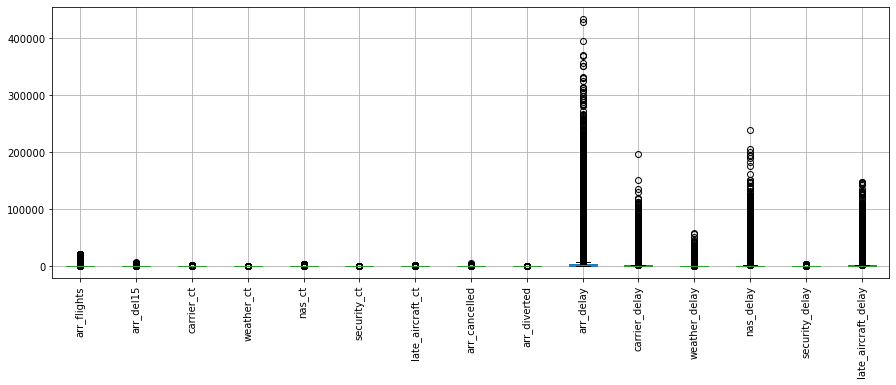

In [15]:
#Boxplot for Outlier detection

outlier_boxplot = df.toPandas().boxplot(column = list_of_numerical_columns, figsize=(15, 5))
outlier_boxplot.plot()
plt.xticks(rotation = 90)
plt.show()

In [16]:
#Removing outliers for the the numerical columns

for i in ["arr_delay", "carrier_delay", "nas_delay", "late_aircraft_delay"]:
    
    percentile_range = df.approxQuantile(i, [0.25, 0.75], 0)
    
    iqr = percentile_range[1] - percentile_range[0]    
    upper = percentile_range[1] + (iqr*1.5)
    lower = percentile_range[0] - (iqr*1.5)
    
    print(i + " :: upper: " + str(upper) + ", lower: " + str(lower))
    df = df.filter(df[i].between(lower, upper))

arr_delay :: upper: 7087.0, lower: -3553.0
carrier_delay :: upper: 1822.5, lower: -893.5
nas_delay :: upper: 869.5, lower: -454.5
late_aircraft_delay :: upper: 1366.5, lower: -749.5


# 5. Coorelation Matrix heatmap

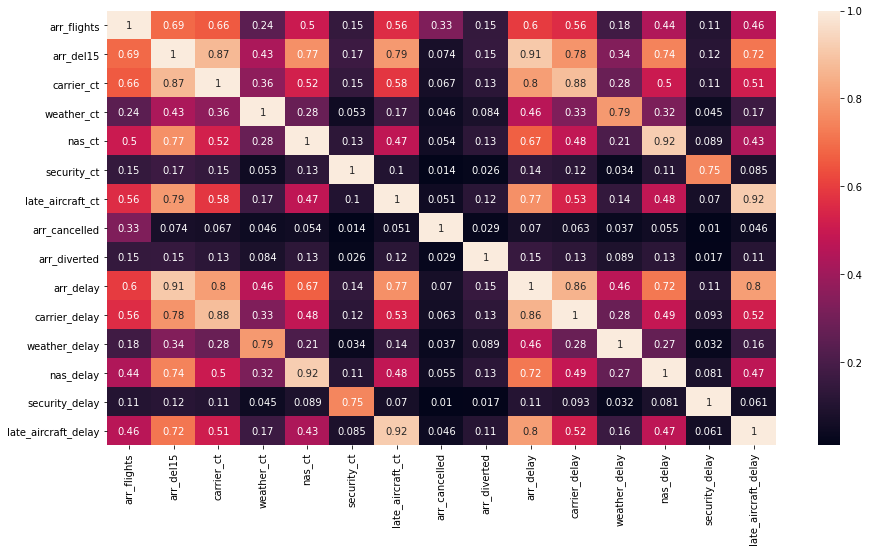

In [17]:
#Coorelation matrix
corrMatrix = df[list_of_numerical_columns].toPandas().corr()
plt.figure(figsize=(15,8))
sns.heatmap(corrMatrix, annot=True)
plt.show()

# Big Data Queries using Spark SQL & Visualizations

In [18]:
# Registering dataframe as temptable
df.registerTempTable("df")

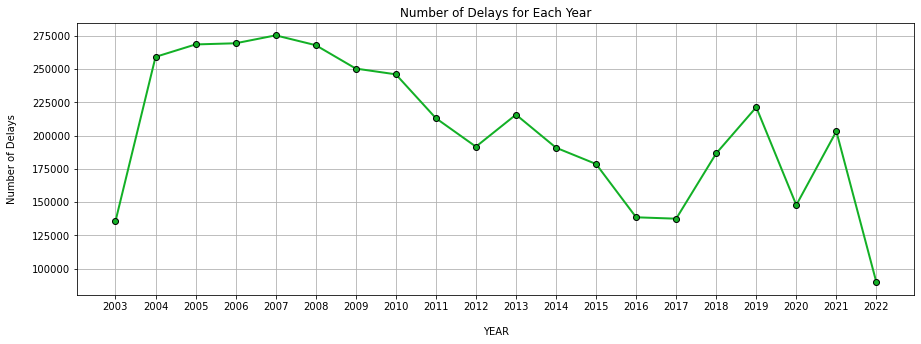

In [19]:
#Number of delays in each year
year_delays = spark.sql("select year, sum(total_number_delays) as number_of_delays from df group by year order by year").toPandas()

plt.figure(figsize=(15,5))
plt.plot(year_delays["year"], year_delays["number_of_delays"], linewidth = 2, color = "#13b026", marker = "o", markeredgecolor = "#000000")
plt.xticks(year_delays["year"])
plt.xlabel("YEAR", labelpad = 15)
plt.ylabel("Number of Delays", labelpad = 15)
plt.title("Number of Delays for Each Year")
plt.grid()
plt.show()

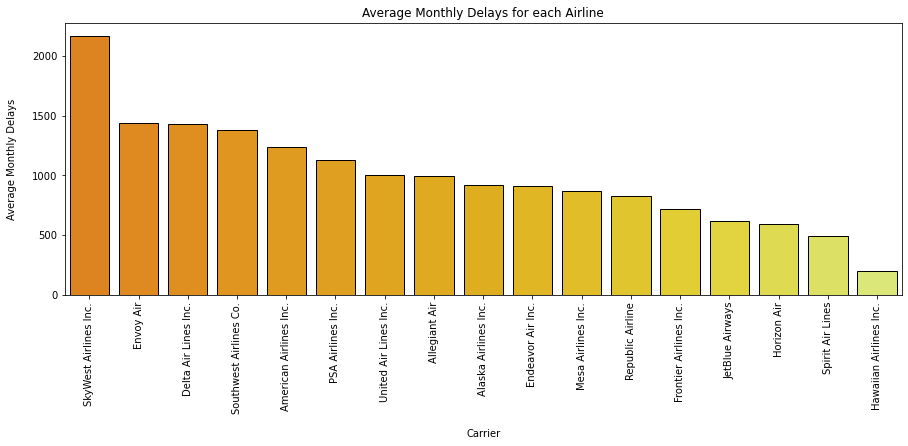

In [20]:
#number of average monthly delays for each carrier for year 2021
monthly_delays = spark.sql("select carrier_name, round(sum(total_number_delays)/12, 4) as average_monthly_delays from df where year = 2021 group by carrier_name order by round(sum(total_number_delays)/12) desc").toPandas()

plt.figure(figsize=(15, 5))
sns.barplot(x = monthly_delays['carrier_name'], y = monthly_delays['average_monthly_delays'], edgecolor = "#000000", palette = 'Wistia_r')
plt.title("Average Monthly Delays for each Airline")
plt.xlabel("Carrier", labelpad = 15)
plt.ylabel("Average Monthly Delays", labelpad = 15)
plt.xticks(rotation = 90)
plt.show()

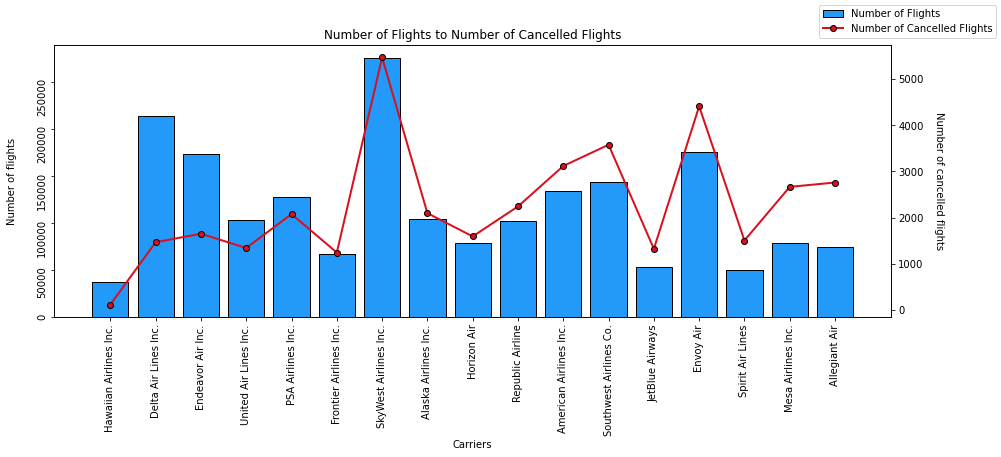

In [21]:
#number of arriving flights, cancelled flights for each carrier in year 2021
arrive_cancelled = spark.sql("select carrier_name, sum(arr_flights) as arriving_flights, sum(arr_cancelled) as cancelled_flights, round(sum(arr_cancelled)/sum(arr_flights), 4) as ratio from df where year >= 2021 group by carrier_name order by ratio").toPandas()
arrive_cancelled.index = arrive_cancelled["carrier_name"]

fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.set_xlabel('Carriers')
ax1.set_ylabel('Number of flights', labelpad = 20)
ax1.bar(arrive_cancelled["carrier_name"], arrive_cancelled["arriving_flights"], edgecolor = "#000000", color = "#2399fa")

ax2 = ax1.twinx()  
ax2.set_ylabel("Number of cancelled flights", labelpad = 20, rotation = 270)
ax2.plot(arrive_cancelled["carrier_name"], arrive_cancelled["cancelled_flights"], linewidth = 2, color = "#db0f1d", marker = "o", markeredgecolor = "#000000")

ax1.tick_params(labelrotation = 90)
fig.legend(["Number of Flights", "Number of Cancelled Flights"])
plt.title("Number of Flights to Number of Cancelled Flights")
plt.show()

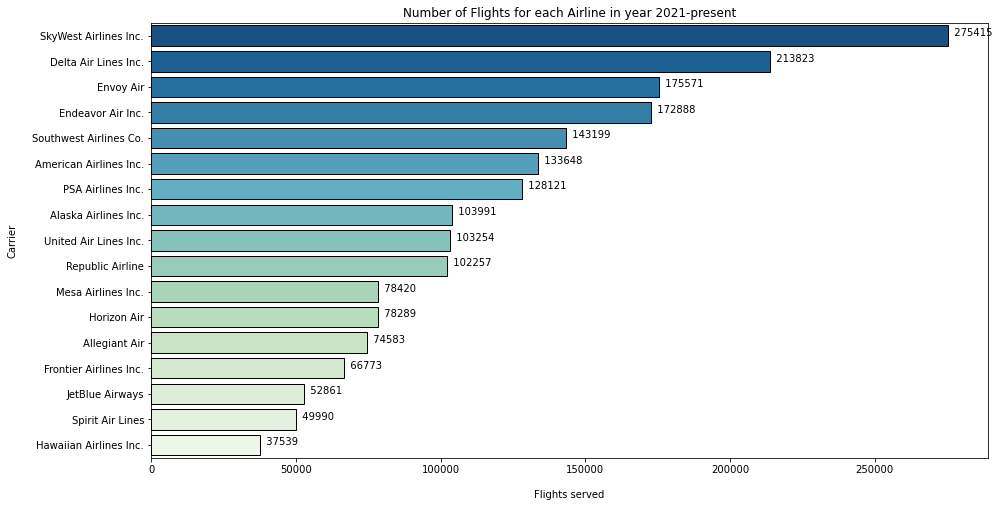

In [22]:
#Number of flights for each carrier
carrier_flights = spark.sql("select carrier_name, sum(arr_flights) as number_of_flights from df where year >= 2021 group by carrier_name order by sum(arr_flights) desc").toPandas()

plt.figure(figsize=(15, 8))
sns.barplot(y = carrier_flights['carrier_name'], x = carrier_flights['number_of_flights'], orient = "h", edgecolor = "#000000", palette = 'GnBu_r')
plt.ylabel("Carrier", labelpad = 15)
plt.xlabel("Flights served", labelpad = 15)

for index, value in enumerate(carrier_flights["number_of_flights"]):
    plt.text(value, index, "  " + str(value))

plt.title("Number of Flights for each Airline in year 2021-present")
plt.show()

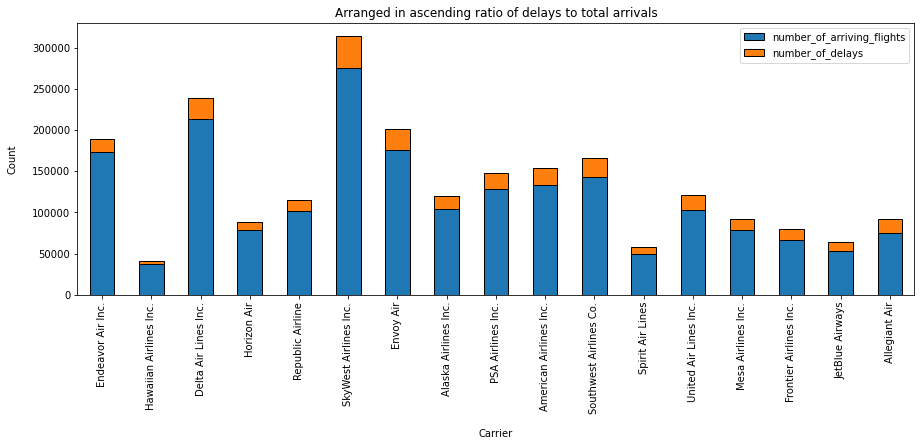

In [23]:
#Ratio of delays to arrived flights
ratio_arr_delay = spark.sql("select carrier_name, sum(arr_flights) as number_of_arriving_flights, sum(total_number_delays) as number_of_delays, round(sum(total_number_delays)/sum(arr_flights), 4) as ratio from df where year >= 2021 group by carrier_name order by round(sum(total_number_delays)/sum(arr_flights), 4)").toPandas()

ratio_arr_delay[["carrier_name", "number_of_arriving_flights", "number_of_delays"]].plot(x = "carrier_name", kind='bar', stacked=True, edgecolor = "#000000", figsize=(15, 5))
plt.xlabel("Carrier", labelpad = 15)
plt.ylabel("Count", labelpad = 15)
plt.title("Arranged in ascending ratio of delays to total arrivals")
plt.show()

In [24]:
#Ratio of delays to delayed_upto_15min for each carrier
spark.sql("select carrier_name, sum(arr_del15) as delayed_upto_15_min, sum(total_number_delays) as total_delays, round(sum(arr_del15)/sum(total_number_delays), 4) as ratio from df where year >= 2021 group by carrier_name order by round(sum(arr_del15)/sum(total_number_delays), 4) desc").show()

+--------------------+-------------------+------------+------+
|        carrier_name|delayed_upto_15_min|total_delays| ratio|
+--------------------+-------------------+------------+------+
|  Mesa Airlines Inc.|              14671|       14189| 1.034|
|    Spirit Air Lines|               8704|        8422|1.0335|
|     JetBlue Airways|              11268|       10978|1.0264|
|       Allegiant Air|              17736|       17353|1.0221|
|   PSA Airlines Inc.|              20074|       19691|1.0195|
|American Airlines...|              21159|       20774|1.0185|
|    Republic Airline|              13541|       13314| 1.017|
|Hawaiian Airlines...|               4033|        3971|1.0156|
|           Envoy Air|              25892|       25498|1.0155|
|   Endeavor Air Inc.|              16806|       16556|1.0151|
|         Horizon Air|              10114|        9972|1.0142|
|Alaska Airlines Inc.|              16011|       15818|1.0122|
|Frontier Airlines...|              12815|       12663|

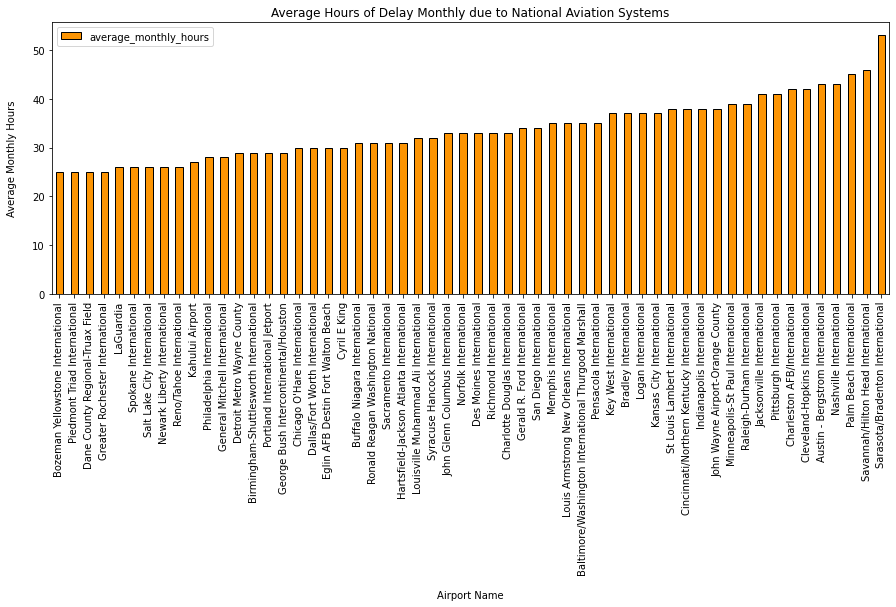

In [25]:
#Average minutes of delay due to National Aviation System greater than 24 hours monthly
nas_delay = spark.sql("select airport_name, round(round(sum(nas_delay)/12)/60) as average_monthly_hours from df where year >= 2021 group by airport_name order by round(sum(nas_delay)/12)").toPandas()
nas_delay = nas_delay[nas_delay["average_monthly_hours"] > 24]

nas_delay.plot.bar(x = 'airport_name', y = 'average_monthly_hours', mark_right = True, figsize=(15, 5), edgecolor = "#000000", color = "#fc9403")
plt.ylabel("Average Monthly Hours", labelpad = 15)
plt.xlabel("Airport Name", labelpad = 15)
plt.title("Average Hours of Delay Monthly due to National Aviation Systems")
plt.show()

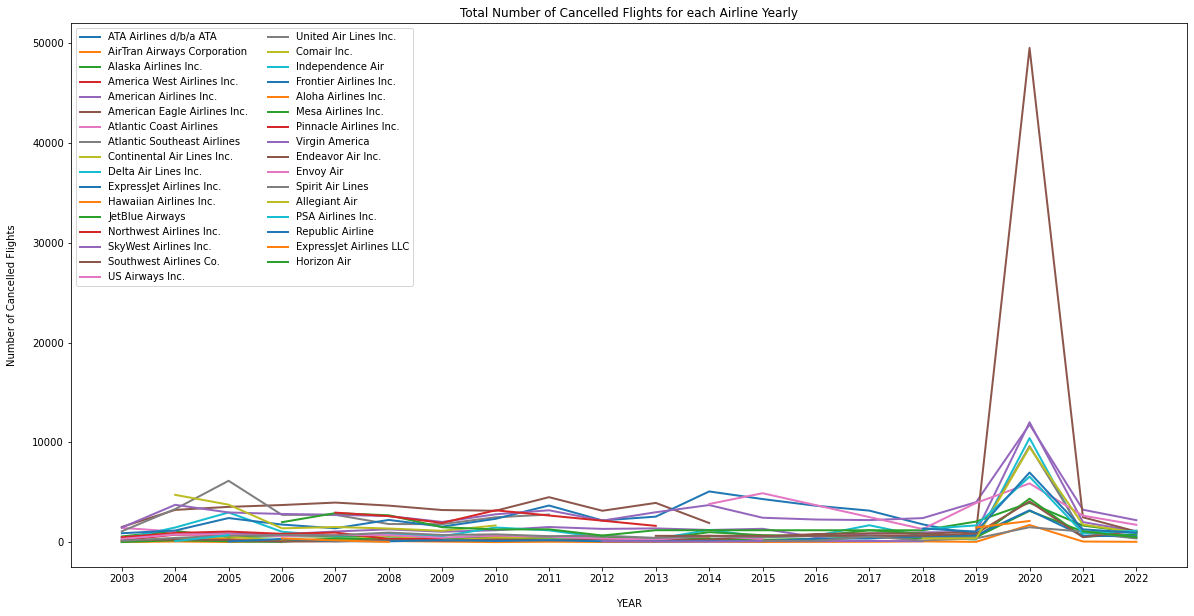

In [26]:
#Number of flights cancelled for each carrier average monthly and total yearly
yearly_cancelled = spark.sql("select year, carrier_name, sum(arr_cancelled) as cancelled_flights from df group by year, carrier_name order by year, carrier_name").toPandas()

plt.figure(figsize=(20, 10))

for i in yearly_cancelled["carrier_name"].unique():
    yearly_cancelled_df = yearly_cancelled[yearly_cancelled["carrier_name"] == i]
    plt.plot(yearly_cancelled_df["year"], yearly_cancelled_df["cancelled_flights"], label = i, linewidth = 2)

plt.legend(ncol=2)
plt.xticks(yearly_cancelled["year"].unique())
plt.ylabel("Number of Cancelled Flights", labelpad = 15)
plt.xlabel("YEAR", labelpad = 15)
plt.title("Total Number of Cancelled Flights for each Airline Yearly")
plt.show()

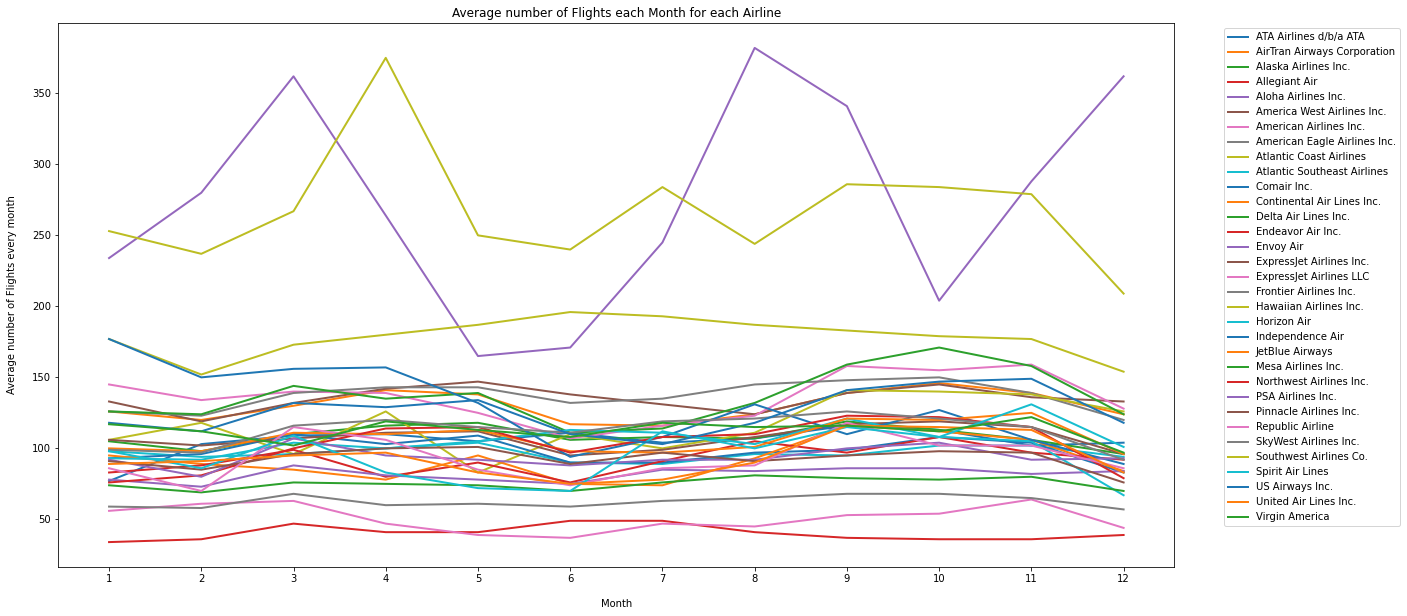

In [27]:
#Average number of flights for each carrier every month
average_flights = spark.sql("select carrier_name, month, cast(round(avg(arr_flights)) as int) as number_of_flights from df group by carrier_name, month order by carrier_name, month").toPandas()

plt.figure(figsize=(20, 10))

for i in average_flights["carrier_name"].unique():
    average_flights_df = average_flights[average_flights["carrier_name"] == i]
    plt.plot(average_flights_df["month"], average_flights_df["number_of_flights"], label = i, linewidth = 2)

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.xticks(average_flights["month"].unique())
plt.ylabel("Average number of Flights every month", labelpad = 15)
plt.xlabel("Month", labelpad = 15)
plt.title("Average number of Flights each Month for each Airline")
plt.show()

In [28]:
#Most security breaches airports

print("Top Airports with most security breaches:")
most_dangerous = spark.sql("select airport_name, round(sum(security_ct)/sum(arr_flights), 4) as ratio_of_security_breaches_to_flights from df group by airport_name order by round(sum(security_ct)/sum(arr_flights), 4) desc limit 15").show()
most_dangerous

Top Airports with most security breaches:
+--------------------+-------------------------------------+
|        airport_name|ratio_of_security_breaches_to_flights|
+--------------------+-------------------------------------+
|    Cold Bay Airport|                               0.0805|
| King Salmon Airport|                               0.0202|
|Pago Pago Interna...|                               0.0046|
|                Adak|                               0.0032|
|        McNary Field|                               0.0024|
|  St. Cloud Regional|                               0.0023|
|St Pete Clearwate...|                               0.0022|
|        Nome Airport|                               0.0021|
|Phoenix - Mesa Ga...|                               0.0019|
|Wiley Post/Will R...|                               0.0018|
|   Riverton Regional|                               0.0017|
|  Dillingham Airport|                               0.0016|
|Ted Stevens Ancho...|                     

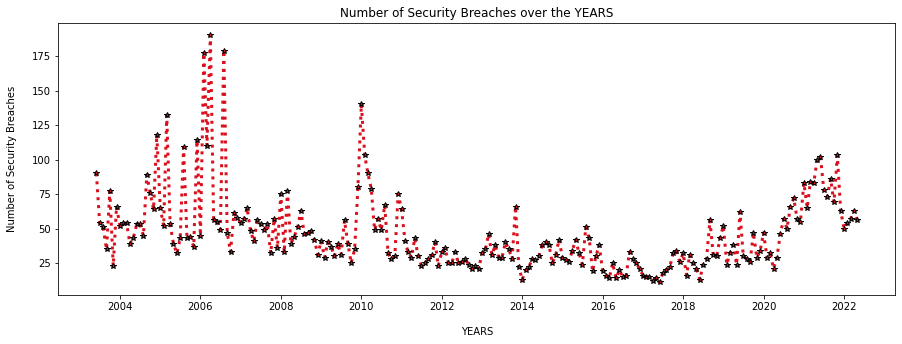

In [29]:
#yearly monthly security breaches
security_breaches = spark.sql("select year, month, cast(concat_ws('-', year, month, 1)as date) as Date, cast(round(sum(security_ct)) as int) as count_of_security_breaches from df group by year, month order by year, month").toPandas()

plt.figure(figsize=(15, 5))
plt.plot(security_breaches["Date"], security_breaches["count_of_security_breaches"], linestyle = ":", linewidth = 3, color = "#db0f1d", marker = "*", markeredgecolor = "#000000")
plt.ylabel("Number of Security Breaches", labelpad = 15)
plt.xlabel("YEARS", labelpad = 15)
plt.title("Number of Security Breaches over the YEARS")
plt.show()

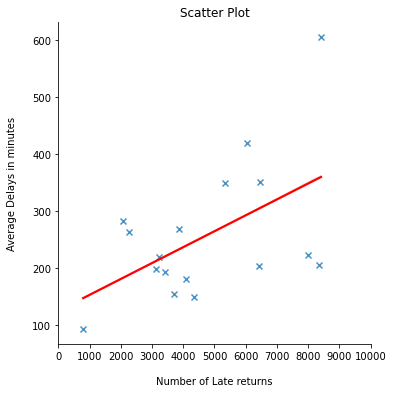

              carrier_name  number_of_late_returns  average_delay_min
0   Southwest Airlines Co.                    8411           605.8804
1    SkyWest Airlines Inc.                    8343           204.2045
2                Envoy Air                    7989           222.2034
3        PSA Airlines Inc.                    6474           350.3755
4            Allegiant Air                    6413           202.9172
5   American Airlines Inc.                    6035           420.0812
6    United Air Lines Inc.                    5329           348.9035
7     Delta Air Lines Inc.                    4339           148.9301
8     Alaska Airlines Inc.                    4096           180.2642
9         Republic Airline                    3861           267.8302
10       Endeavor Air Inc.                    3694           154.0139
11  Frontier Airlines Inc.                    3416           193.2158
12             Horizon Air                    3222           218.6809
13      Mesa Airline

In [30]:
#Delay of each carrier because of returning flights
number_late_returns_delays = spark.sql("select carrier_name, cast(sum(late_aircraft_ct) as int) as number_of_late_returns, round(avg(late_aircraft_delay), 4) as average_delay_min from df where year >= 2021 group by carrier_name order by 2 desc, 3 desc").toPandas()


sns.lmplot(x = "number_of_late_returns", y = "average_delay_min", data = number_late_returns_delays, ci = 0.95, markers = 'x', line_kws={'color': 'red'})
plt.ylabel("Average Delays in minutes", labelpad = 15)
plt.xlabel("Number of Late returns", labelpad = 15)
plt.title("Scatter Plot")
plt.xticks(range(0, 11000, 1000))
plt.show()
print(number_late_returns_delays)

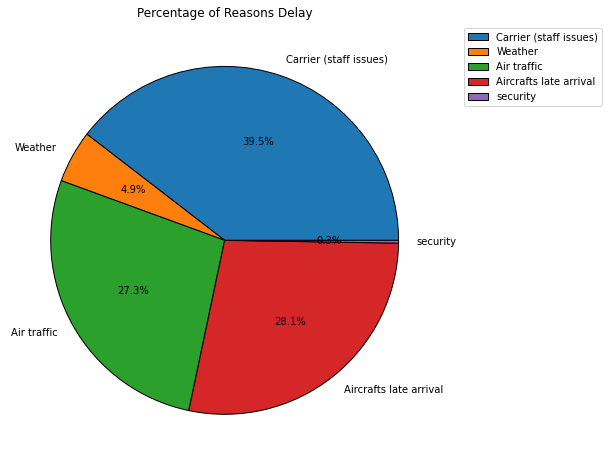

In [31]:
#Delayed pie chart
delayed_reasons = spark.sql("select sum(carrier_ct), sum(weather_ct), sum(nas_ct), sum(late_aircraft_ct), sum(security_ct) from df").toPandas()

plt.figure(figsize=(15, 8))
labels = ["Carrier (staff issues)", "Weather", "Air traffic", "Aircrafts late arrival", "security"]
plt.pie(delayed_reasons.values.tolist()[0], labels = labels, autopct = '%1.1f%%',
        wedgeprops = {"edgecolor" : "black",
                      'linewidth': 1,
                      'antialiased': True})

plt.title("Percentage of Reasons Delay")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show() 

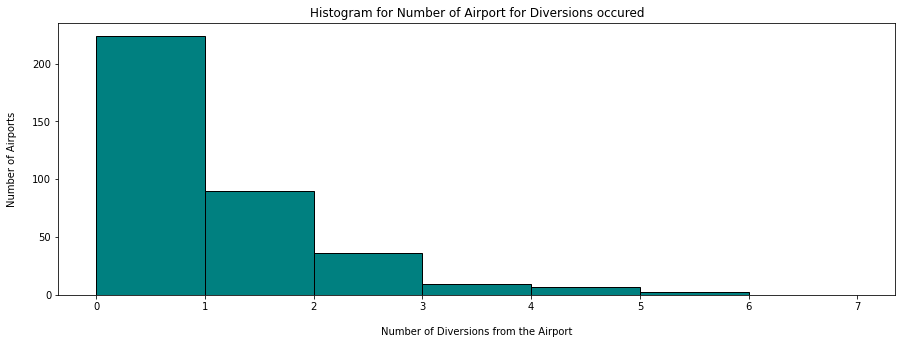

In [32]:
#diverted airports
diverted_df = spark.sql("select airport_name, cast(sum(arr_diverted)/12 as int) as average_monthly_diverted from df where year >= 2021 group by airport_name order by sum(arr_diverted)/12 desc").toPandas()

plt.figure(figsize=(15, 5))
plt.hist(diverted_df["average_monthly_diverted"], bins=[0,1,2,3,4,5,6,7], edgecolor = "#000000", color = "#008080")
plt.ylabel("Number of Airports", labelpad = 15)
plt.xlabel("Number of Diversions from the Airport", labelpad = 15)
plt.title("Histogram for Number of Airport for Diversions occured")
plt.show()

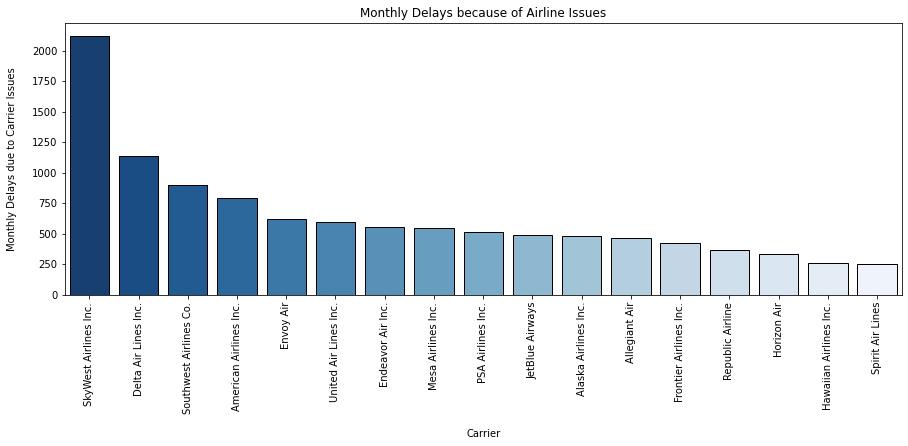

In [33]:
#Delay due to carrier issues
carrier_delay = spark.sql("select carrier_name, cast(sum(carrier_ct)/12 as int) as monthly_number_of_delays from df where year >= 2021 group by carrier_name order by sum(carrier_ct)/12 desc").toPandas()

plt.figure(figsize=(15, 5))
sns.barplot(x = carrier_delay['carrier_name'], y = carrier_delay['monthly_number_of_delays'], edgecolor = "#000000", palette='Blues_r')
plt.xlabel("Carrier", labelpad = 15)
plt.ylabel("Monthly Delays due to Carrier Issues", labelpad = 15)
plt.title("Monthly Delays because of Airline Issues")
plt.xticks(rotation = 90)
plt.show()

# Linear Regression

In [90]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

In [106]:
assembler = VectorAssembler(inputCols = ['carrier_ct', 'weather_ct', 'nas_ct', 'late_aircraft_ct', 'carrier_delay', 'nas_delay'], outputCol = "features")
output_df = assembler.transform(df)

In [107]:
lr_df = output_df.select("features", "arr_delay")

In [108]:
train_df, test_df = lr_df.randomSplit([0.8, 0.2])

In [109]:
lm = LinearRegression(labelCol = "arr_delay")

In [110]:
model = lm.fit(train_df)

In [111]:
model.coefficients

DenseVector([-12.445, 73.0276, -13.4153, 56.425, 1.2191, 1.4199])

In [112]:
results = model.evaluate(test_df)

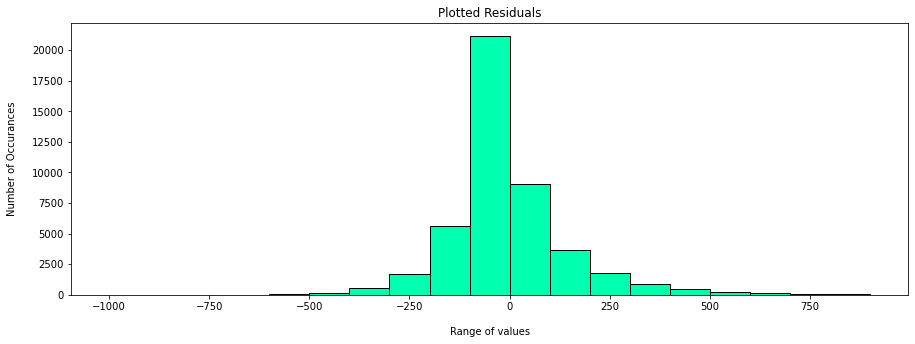

In [123]:
plt.figure(figsize=(15, 5))
plt.hist(results.residuals.toPandas(), bins=range(-1000, 1000, 100), edgecolor = "#000000", color = "#00ffae")
plt.ylabel("Number of Occurances", labelpad = 15)
plt.xlabel("Range of values", labelpad = 15)
plt.title("Plotted Residuals")
plt.show()

In [114]:
predict = model.transform(test_df.select("features"))

In [115]:
results.r2

0.9582901867099903

In [116]:
results.r2adj

0.9582847211102755

In [117]:
results.meanAbsoluteError

101.99269641107665

In [118]:
results.meanSquaredError

26478.59087561985

In [119]:
results.rootMeanSquaredError

162.7224350715655

# K-Means

In [124]:
from pyspark.ml.feature import StandardScaler